# Imports

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import time
import copy
import os


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']

# Getting Data

In [3]:
%time mit_calls = pc.allcalls('CallLog.csv', (), 'participantID.A', 'number.hash', ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
mit_calls.head()

CPU times: user 436 ms, sys: 24.7 ms, total: 460 ms
Wall time: 492 ms


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,307,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,450,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,328,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,454,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,400,0


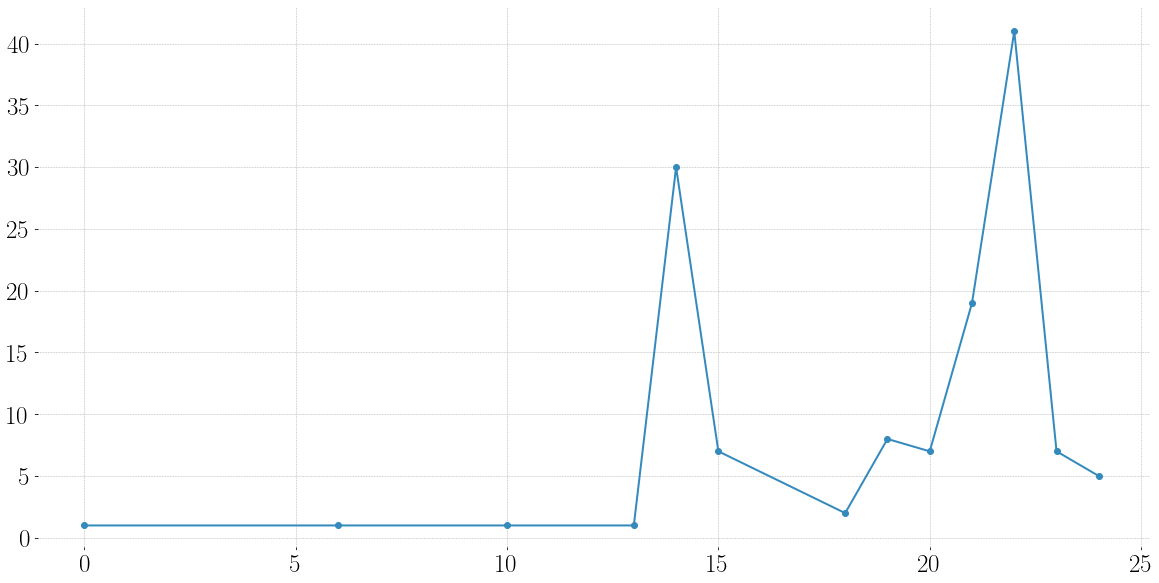

In [11]:
H = {}
for ell in mit_calls.groupby(['ego'])[['uclock']].min()['uclock']:
    lamb = ell // 10
    H[lamb] = H.get(lamb, 0) + 1
df = pd.DataFrame.from_dict(H, orient='index')
df.sort_index(inplace=True)
plt.plot(df.index, df[0], "-o")

In [104]:
%time mit_pairs = pc.pairs(mit_calls)
mit_pairs.head()

CPU times: user 37.5 ms, sys: 0 ns, total: 37.5 ms
Wall time: 36.7 ms


,ego,alter,nij,k,n
0,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,1,516,3339
1,fa10-01-01,abac98a7f6c000a6600c0e9cc370b059a874c3fd,1,516,3339
2,fa10-01-01,b8bc40aefbb724dfbacb3fd296cbb10b2dd35a85,6,516,3339
3,fa10-01-01,b8b0f0fc34d4201df3ebb5ebcefbbb61a3499941,1,516,3339
4,fa10-01-01,b8af4e561030e5a28b441467ede33b9450dd8518,1,516,3339


In [168]:
%time mit_lives = pc.lives_dictionary(mit_calls)
# just to show how an entry looks like
mit_lives['fa10-01-01']['102c517fc9ecf84975448470893c3799f5588c8a']

CPU times: user 149 ms, sys: 3.34 ms, total: 152 ms
Wall time: 151 ms


{'t0': 454, 'tf': 454, 'nij': 1, 'ell': 0}

In [169]:
%time mit_calls = pc.remove_alters(mit_calls, mit_lives, 180) # only keep alters and phone calls appeared after 6 months, counting from the start of the data
mit_calls.head()

CPU times: user 2.23 s, sys: 16.3 ms, total: 2.25 s
Wall time: 2.25 s


,ego,alter,time,uclock,aclock
0,fa10-01-19,10153fa58c24d1a2eb54b3c6ac39482acb61131c,2010-12-31 16:44:24,127,0
1,fa10-01-22,101b96d65031e2792acd950125d90cf9ff30b5ac,2011-05-23 20:59:05,270,0
2,fa10-01-12,1023b616632f3ba048b2f1d1374788bfa0444a8d,2011-01-22 14:01:07,148,0
3,fa10-01-01,102c517fc9ecf84975448470893c3799f5588c8a,2011-05-27 17:52:56,274,0
4,fa10-01-07,102cd812edb5689302bcc57df8330cff44727bd1,2011-04-04 10:02:50,220,0


In [170]:
%time mit_pairs = pc.pairs(mit_calls)
%time mit_lives = pc.lives_dictionary(mit_calls)

CPU times: user 31.1 ms, sys: 13 µs, total: 31.1 ms
Wall time: 30.3 ms
CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 131 ms


In [7]:
%time uk_calls = pc.allcalls("../ukdata/collected_dunbar_calls_v3_e26OK_sorted.csv", (3, 'call'), 1, 2, [6,7], '%d/%m/%y %H:%M', header=False, min_activity=1)
uk_calls.head()

CPU times: user 619 ms, sys: 18.7 ms, total: 638 ms
Wall time: 664 ms


,ego,alter,time,uclock,aclock
0,C07814508939,C0020165636994,2008-02-07 16:18:00,339,0
1,C07814508939,C0020165636994,2008-02-07 17:11:00,339,0
2,C07814508939,C0020165636994,2008-02-20 15:39:00,352,13
3,C07792658311,C0021213487966,2008-02-27 17:01:00,359,0
4,C07792658311,C0021213487966,2008-02-27 17:55:00,359,0


In [8]:
%time uk_pairs = pc.pairs(uk_calls)
%time uk_lives = pc.lives_dictionary(uk_calls)

CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 21.6 ms
CPU times: user 66 ms, sys: 0 ns, total: 66 ms
Wall time: 65.9 ms


In [9]:
tmp = uk_calls.copy(deep=True)
rmalter = {}
for ego in uk_lives.keys():
    rmalter[ego] = []
    for alter in uk_lives[ego].keys():
        if uk_lives[ego][alter]['t0'] < 180:
            rmalter[ego].append(alter)
            
for i in tmp.index:
    ego = tmp.at[i, 'ego']
    alter = tmp.at[i, 'alter']
    if alter in rmalter[ego]:
        tmp.at[i, 'rm'] = 1
    else:
        tmp.at[i, 'rm'] = 0
        
tmp2 = tmp.loc[tmp['rm'] == 0]
tmp2 = tmp2.loc[tmp2['uclock'] >= 180]
tmp2['uclock'] -= 180
tmp2.to_csv("tmp2.csv")
%time uk2_calls = pc.allcalls("tmp2.csv", (), 'ego', 'alter', ['time'], '%Y-%m-%d %H:%M:%S')
os.system("rm tmp2.csv")
uk1_calls = tmp.loc[tmp['rm'] == 1]
uk1_calls.drop(columns=['rm'], inplace=True)

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 115 ms


/home/vsvh/.local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
tmp['rm'].value_counts()

1.0    75924
0.0    31618
Name: rm, dtype: int64

In [11]:
len(uk2_calls)

31618

In [12]:
uk1_pairs = pc.pairs(uk1_calls)
uk2_pairs = pc.pairs(uk2_calls)

uk1_lives = pc.lives_dictionary(uk1_calls)
uk2_lives = pc.lives_dictionary(uk2_calls)

# Get $F$

This is a required step to obtain $b$

In [13]:
%time mit_f = pc.get_f(mit_calls, 'all', 180, 60)

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 21.7 s, sys: 39 ms, total: 21.7 s
Wall time: 21.8 s


# From $F$ to $b$

In [14]:
%time mit_b = pc.get_b(mit_f, 'lambda')
%time mit_bplot = pc.plot_g(mit_b, 'lambda')

CPU times: user 2.53 s, sys: 15 ms, total: 2.55 s
Wall time: 2.56 s
CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 19.4 ms


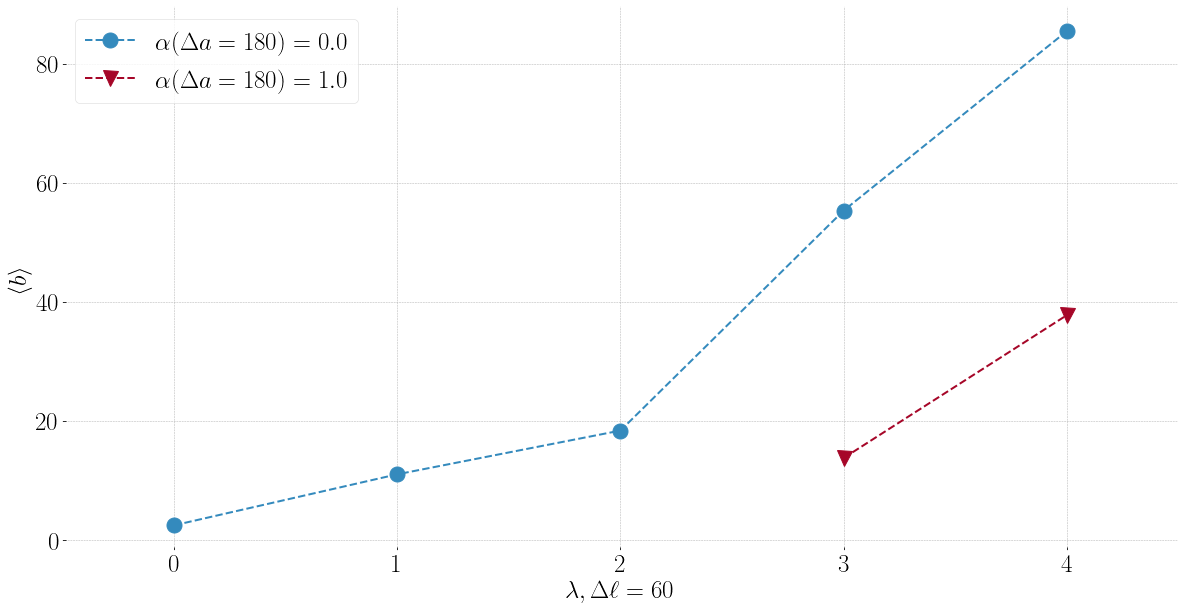

In [15]:
plt.xlabel(r"$\lambda, \Delta \ell = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in mit_bplot.keys():
    plt.plot(mit_bplot[a].index, mit_bplot[a]['lambda'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\alpha(\Delta a  = 180) = {a}$")
plt.legend()

In [16]:
%time mit_f2 = pc.get_f(mit_calls, 'all', 60, 180)
%time mit_b2 = pc.get_b(mit_f2, 'alpha')
%time mit_bplot2 = pc.plot_g(mit_b2, 'alpha')

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.sort_values(by='time', inplace=True)
/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['alpha'] = df3['aclock'] // bina


CPU times: user 22.2 s, sys: 16.2 ms, total: 22.2 s
Wall time: 22.2 s
CPU times: user 2.63 s, sys: 26.7 ms, total: 2.66 s
Wall time: 2.66 s
CPU times: user 21 ms, sys: 0 ns, total: 21 ms
Wall time: 20.9 ms


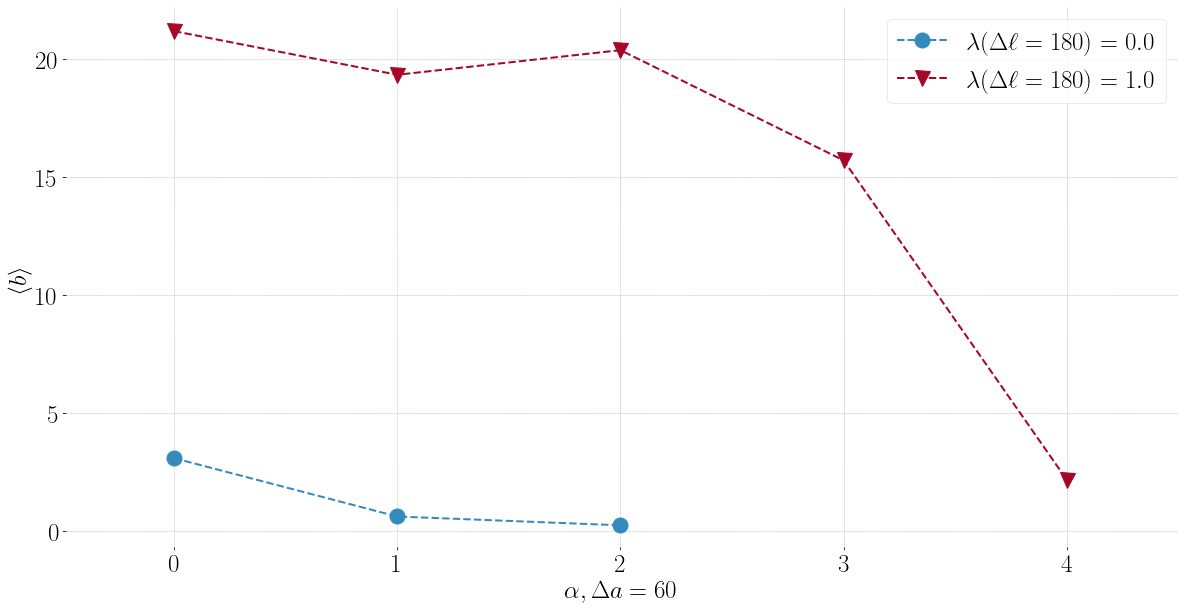

In [17]:
plt.xlabel(r"$\alpha, \Delta a = 60$")
plt.ylabel(r"$\langle b \rangle$")
plt.xlim(-0.5, 4.5)
plt.xticks(range(5))
for a in mit_bplot2.keys():
    plt.plot(mit_bplot2[a].index, mit_bplot2[a]['alpha'], marker=markers[int(a)], markersize=15, linestyle="--", label=fr"$\lambda(\Delta \ell  = 180) = {a}$")
plt.legend()

# Distributions of lifetime separated by $b$

Separated by activity. I will do this as a test using only $b$; but the idea is that evetually I'll use $F$

In [18]:
egolist = list(mit_calls['ego'].unique())

In [19]:
pd.set_option('mode.chained_assignment', None)

In [20]:
%time mit_f = pc.get_f(mit_calls, 'all', 60, 7)

CPU times: user 22.2 s, sys: 29.4 ms, total: 22.2 s
Wall time: 22.2 s


In [21]:
%time mit_b = pc.get_b(mit_f, 'lambda')

CPU times: user 4.09 s, sys: 53 µs, total: 4.09 s
Wall time: 4.09 s


In [22]:
allb = []
for ego in mit_b.keys():
    df = mit_b[ego].loc[mit_b[ego]['alpha'] == 1]
    for i in df.index:
        allb.append(df.at[i, 'g'])
        
[max(allb), min(allb), len(allb)]

[360.0, 0.25, 1182]

(array([651., 234.,  89.,  42.,  36.,  17.,  14.,  11.,  12.,   3.,   9.,
          6.,   4.,   4.,   3.,   0.,   7.,   1.,   2.,   2.,   0.,   3.,
          2.,   2.,   0.,   0.,   0.,   0.,   1.,   3.,   1.,   2.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,
          1.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.500000e-01, 3.847500e+00, 7.445000e+00, 1.104250e+01,
        1.464000e+01, 1.823750e+01, 2.183500e+01, 2.543250e+01,
        2.903000e+01, 3.262750e+01, 3.622500e+01, 3.982250e+01,
        4.342000e+01, 4.701750e+01, 5.061500e+01, 5.421250e+01,
        5.781000e+01, 6.140750e+01, 6.500500e+01, 6.860250e+01

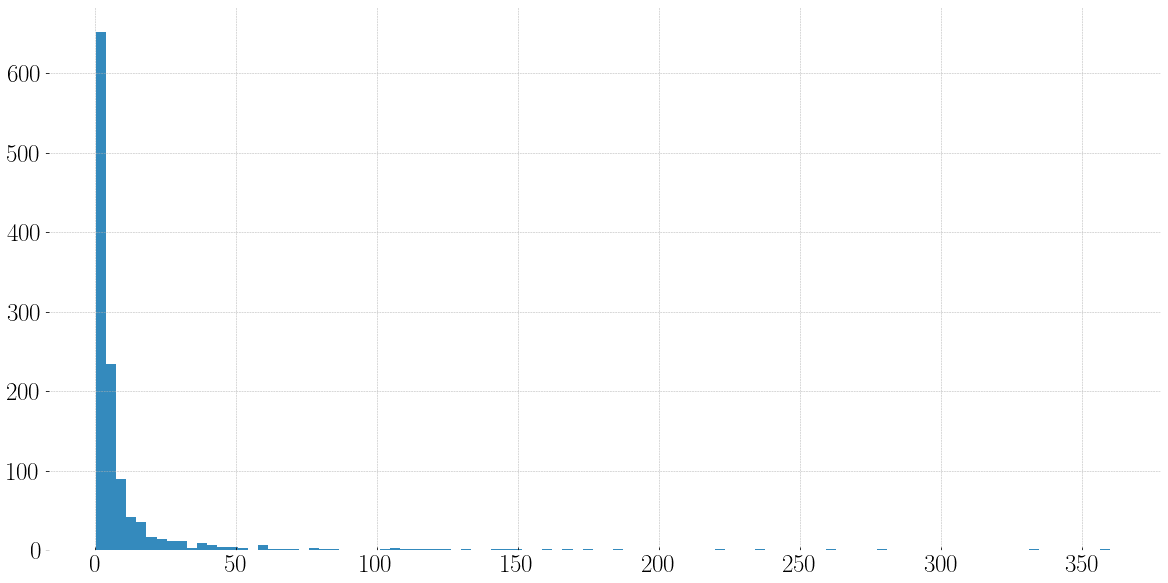

In [23]:
plt.hist(allb, bins=100)

How to decide on the bins for $b$? For now, I will try to arbitrarily choose based on the distribution.

In [24]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in mit_b.keys():
    df = mit_b[ego].loc[mit_b[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < 17:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= 17) and (b < 34):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

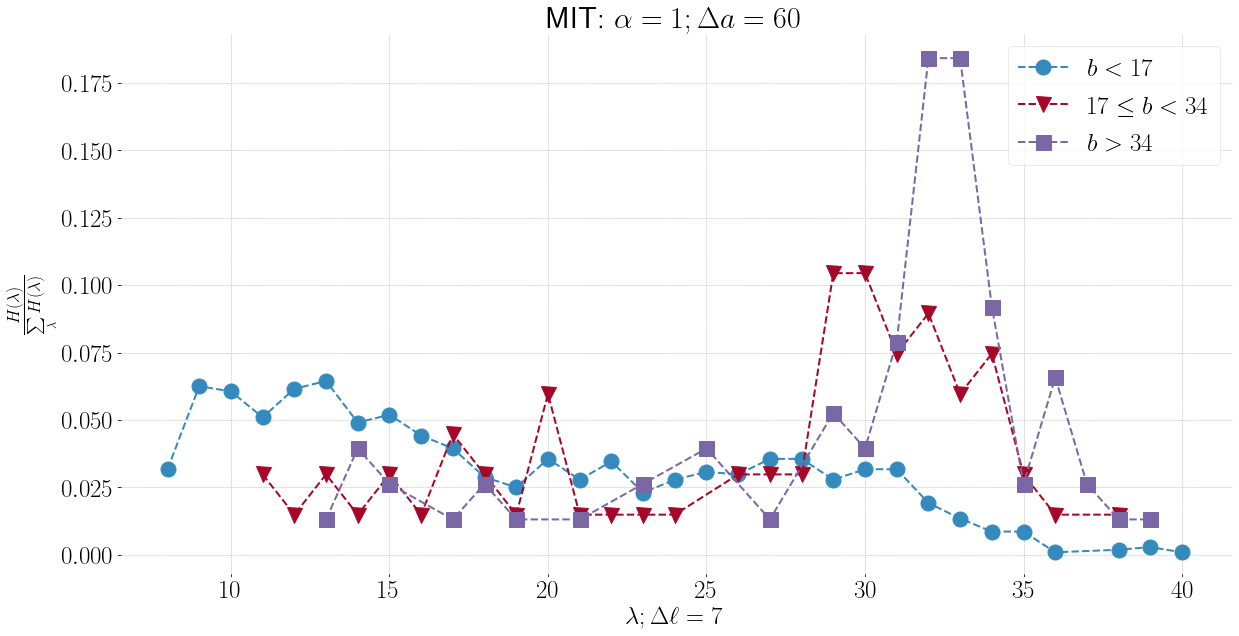

In [25]:
legends = [r"$b < 17$", r"$17 \leq b < 34$", r"$b > 34$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

But I could also choose bins in terms of the perrcentiles (33, 66, 100)

In [26]:
p33, p66 = np.percentile(allb, 33), np.percentile(allb, 66)
test = {}
for i in range(4):
    test[i] = {}
    
for ego in mit_b.keys():
    df = mit_b[ego].loc[mit_b[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < p33:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= p33) and (b < p66):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

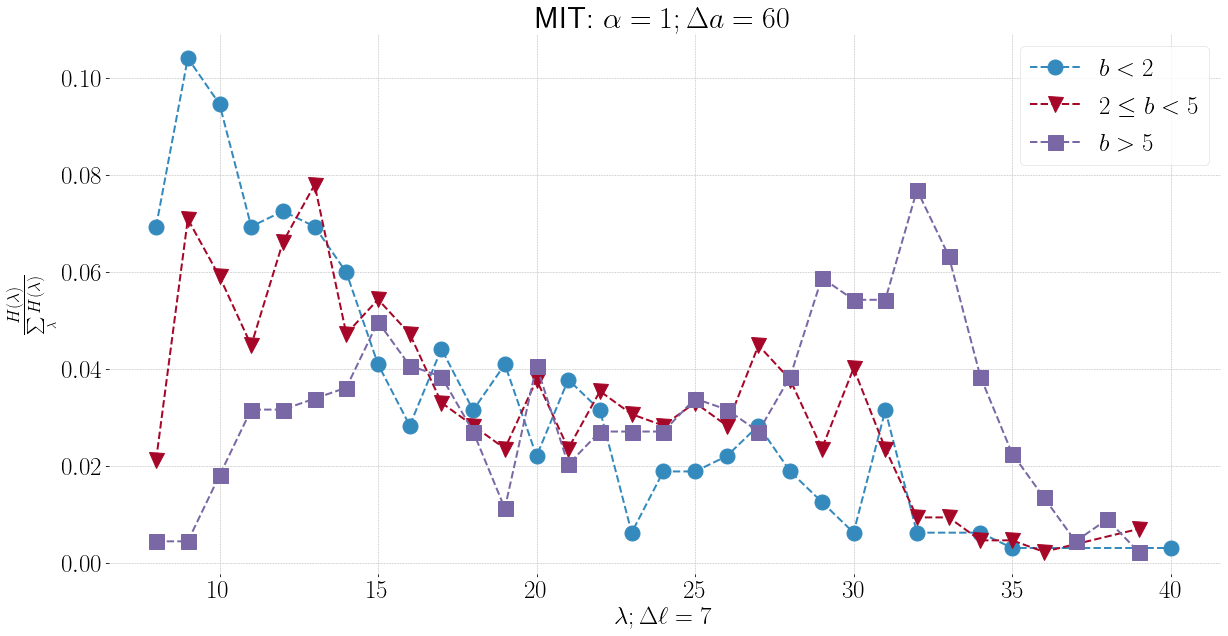

In [27]:
legends = [fr"$b < {int(p33)}$", fr"${int(p33)} \leq b < {int(p66)}$", fr"$b > {int(p66)}$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

## Function to Produce the series

In [28]:
def b_histell(bresult, alpha_fixed, cut_points):
    test = {}
    for i in range(len(cut_points) + 1):
        test[i] = {}

    for ego in bresult.keys():
        df = bresult[ego].loc[bresult[ego]['alpha'] == alpha_fixed]
        for i in df.index:
            lamb = df.at[i, 'lambda']
            b = df.at[i, 'g']
            test[len(cut_points)][lamb] = test[len(cut_points)].get(lamb, 0) + 1
            for c in range(len(cut_points)):
                if (c == 0) and (b < cut_points[0]):
                    test[c][lamb] = test[c].get(lamb, 0) + 1
                elif (c in range(1, len(cut_points) - 1)) and (b >= cut_points[c - 1]) and (b < cut_points[c]):
                    test[c][lamb] = test[c].get(lamb, 0) + 1
                elif (c == len(cut_points) - 1) and  (b >= cut_points[-2]):
                    test[c][lamb] = test[c].get(lamb, 0) + 1

    for i in test.keys():
        test[i] = pd.DataFrame.from_dict(test[i], orient='index')
        test[i].sort_index(inplace=True)
        
    return test

In [29]:
%time mit_bdist = b_histell(mit_b, 1, [np.percentile(allb, p) for p in [33, 66, 100]])

CPU times: user 50.9 ms, sys: 108 µs, total: 51 ms
Wall time: 48.7 ms


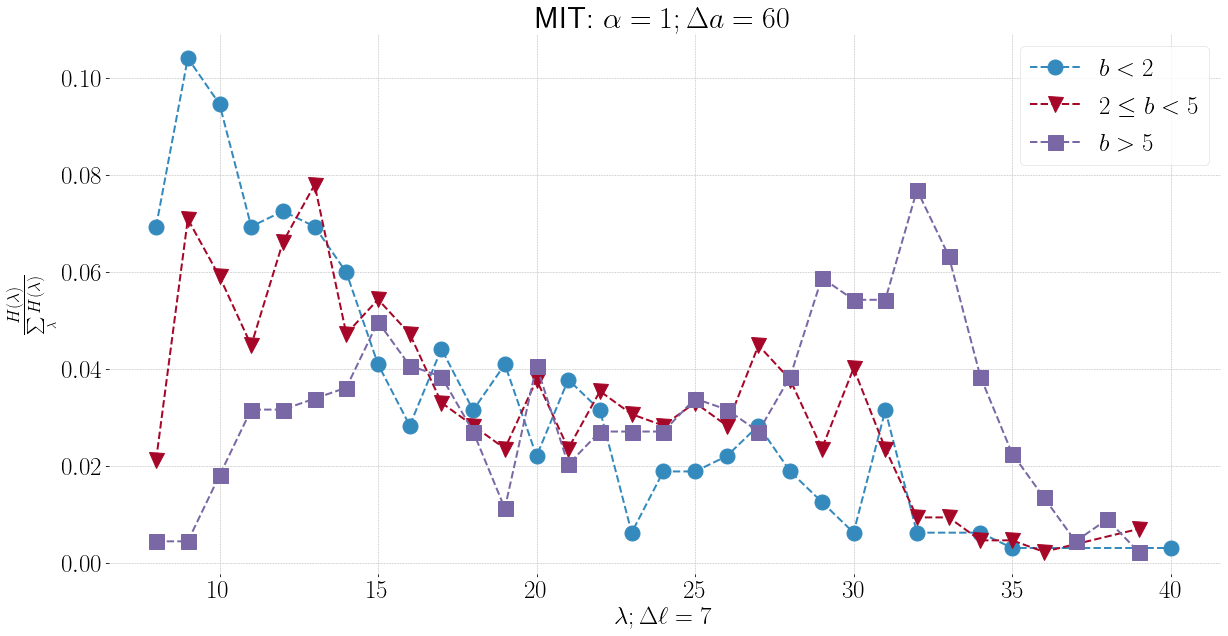

In [30]:
legends = [fr"$b < {int(p33)}$", fr"${int(p33)} \leq b < {int(p66)}$", fr"$b > {int(p66)}$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(mit_bdist) - 1):
    plt.plot(mit_bdist[i].index, mit_bdist[i][0] / sum(mit_bdist[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Distributions of lifetime separated by $F$

In [31]:
mit_allf = []
for ego in mit_f.keys():
    for alter in mit_f[ego].keys():
        df = mit_f[ego][alter].loc[mit_f[ego][alter]['alpha'] == 1]
        for i in df['lambda']:
            mit_allf.append(i)
        
[max(mit_allf), min(mit_allf), len(mit_allf)]

[40, 8, 1741]

In [32]:
p = [np.percentile(mit_allf, q) for q in (33, 66)]
p

[14.0, 25.0]

(array([ 41.,   0.,   0., 114.,   0.,   0.,  95.,   0.,   0.,  78.,   0.,
          0., 109.,   0.,   0., 112.,   0.,   0.,  80.,   0.,   0.,  85.,
          0.,   0.,   0.,  72.,   0.,   0.,  60.,   0.,   0.,  40.,   0.,
          0.,  35.,   0.,   0.,  48.,   0.,   0.,  44.,   0.,   0.,  52.,
          0.,   0.,  37.,   0.,   0.,   0.,  43.,   0.,   0.,  49.,   0.,
          0.,  50.,   0.,   0.,  61.,   0.,   0.,  50.,   0.,   0.,  56.,
          0.,   0.,  57.,   0.,   0.,  60.,   0.,   0.,   0.,  73.,   0.,
          0.,  52.,   0.,   0.,  36.,   0.,   0.,  25.,   0.,   0.,  12.,
          0.,   0.,   4.,   0.,   0.,   4.,   0.,   0.,   6.,   0.,   0.,
          1.]),
 array([ 8.  ,  8.32,  8.64,  8.96,  9.28,  9.6 ,  9.92, 10.24, 10.56,
        10.88, 11.2 , 11.52, 11.84, 12.16, 12.48, 12.8 , 13.12, 13.44,
        13.76, 14.08, 14.4 , 14.72, 15.04, 15.36, 15.68, 16.  , 16.32,
        16.64, 16.96, 17.28, 17.6 , 17.92, 18.24, 18.56, 18.88, 19.2 ,
        19.52, 19.84, 20.16, 20.48

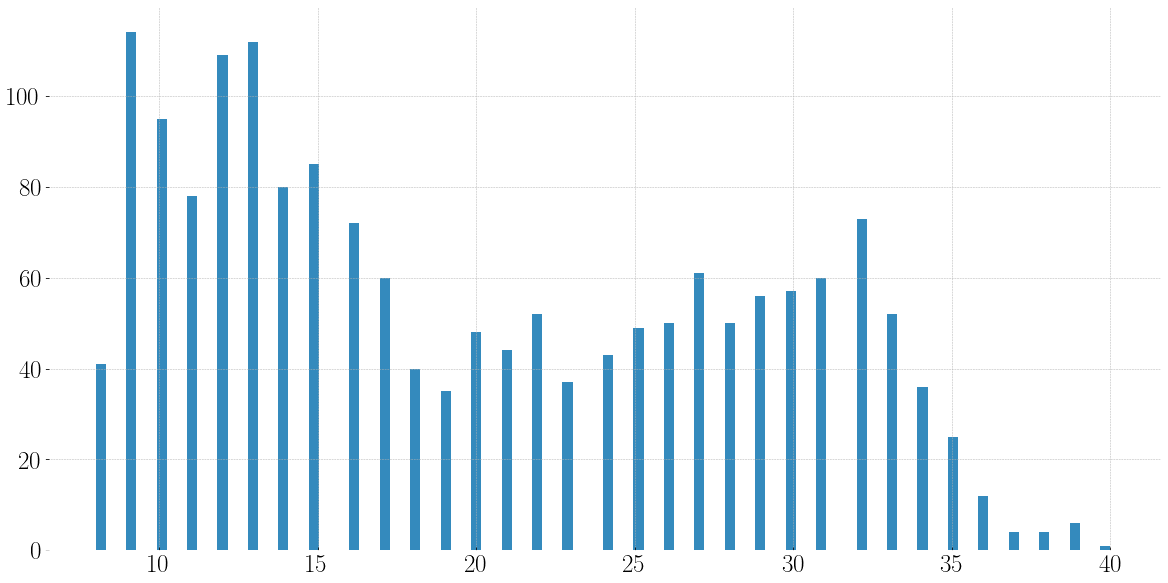

In [33]:
plt.hist(mit_allf, bins=100)

In [34]:
test = {}
for i in range(4):
    test[i] = {}
    
for ego in mit_f.keys():
    for alter in mit_f[ego].keys():
        df = mit_f[ego][alter].loc[mit_f[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                if f < p[0]:
                    test[0][lamb] = test[0].get(lamb, 0) + 1
                elif (f >= p[0]) and (f < p[1]):
                    test[1][lamb] = test[1].get(lamb, 0) + 1
                else:
                    test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

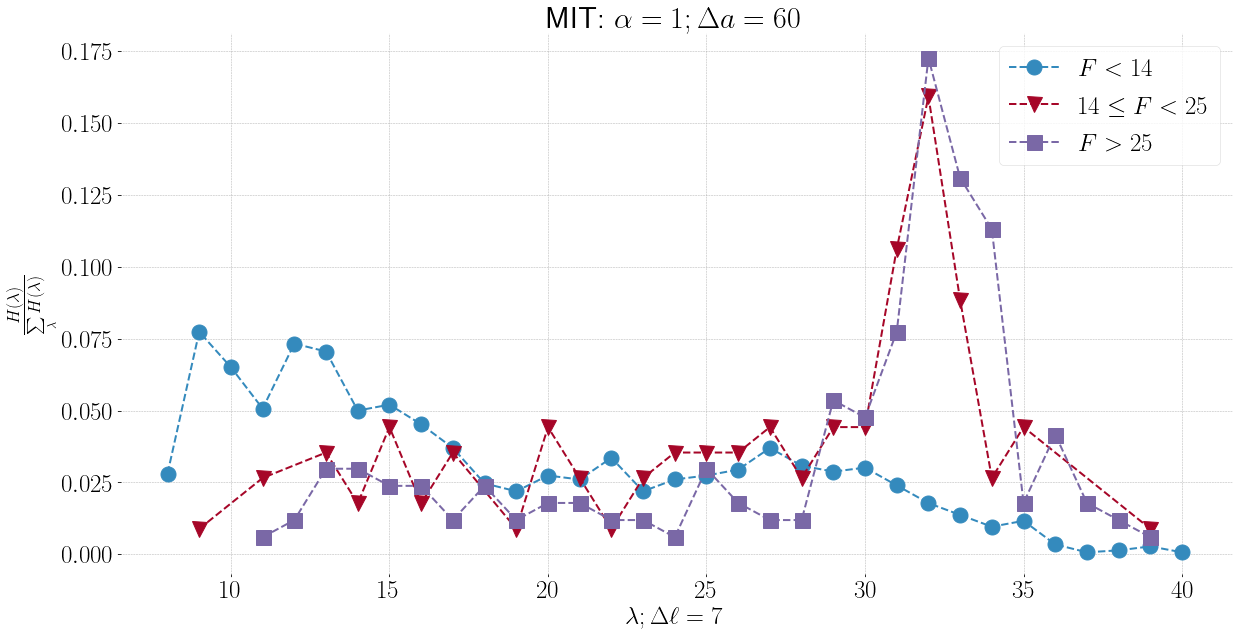

In [35]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

## Function to produce the series

In [36]:
def f_histell(fresult, alpha_fixed, cut_points):
    n = 1
    test = {}
    for i in range(len(cut_points) + 1):
        test[i] = {}
    for ego in fresult.keys():
        for alter in fresult[ego].keys():
            df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
            if len(df) > 0:
                lamb = df.iloc[0]['lambda']
                for f in df['f']:
                    test[len(cut_points)][lamb] = test[len(cut_points)].get(lamb, 0) + 1
                    for c in range(len(cut_points)):
                        if (c == 0) and (f < cut_points[0]):
                            test[c][lamb] = test[c].get(lamb, 0) + 1
                        elif (c in range(1, len(cut_points) - 1)) and (f >= cut_points[c - 1]) and (f < cut_points[c]):
                            test[c][lamb] = test[c].get(lamb, 0) + 1
                        elif (c == len(cut_points) - 1) and  (f >= cut_points[-2]):
                            test[c][lamb] = test[c].get(lamb, 0) + 1
                

    for i in test.keys():
        test[i] = pd.DataFrame.from_dict(test[i], orient='index')
        test[i].sort_index(inplace=True)
        
    return test

In [37]:
%time mit_fdist = f_histell(mit_f, 1, [np.percentile(mit_allf, p) for p in [33, 66, 100]])

CPU times: user 2.89 s, sys: 0 ns, total: 2.89 s
Wall time: 2.89 s


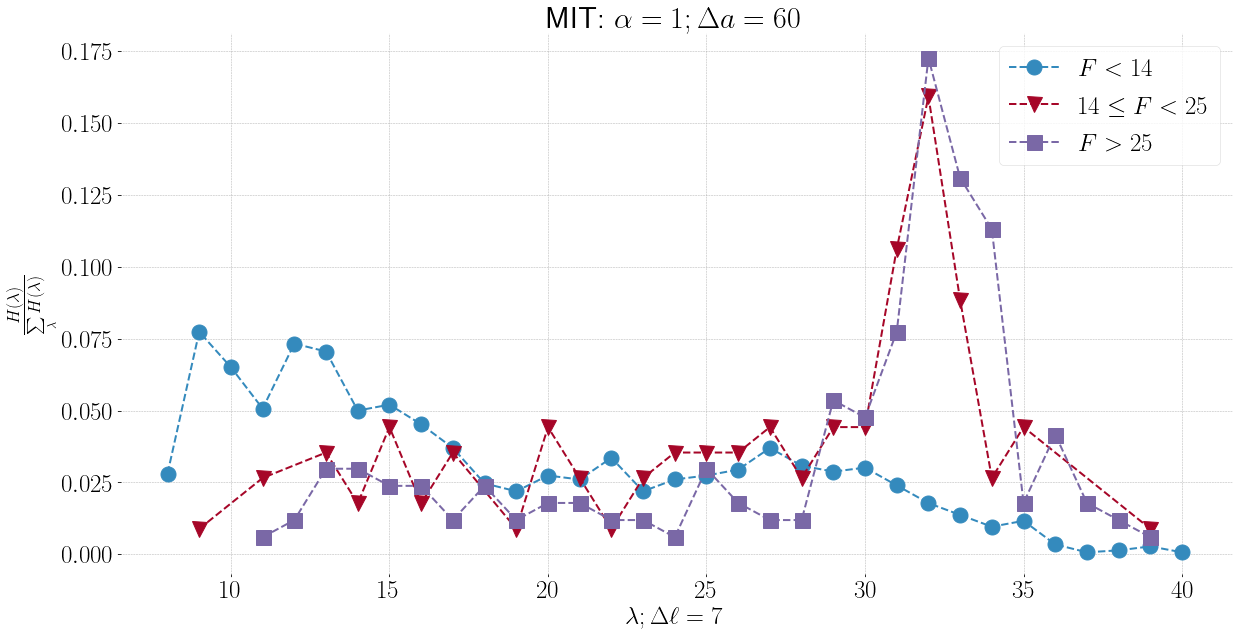

In [38]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(mit_fdist) - 1):
    plt.plot(mit_fdist[i].index, mit_fdist[i][0] / sum(mit_fdist[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Limiting data

The first step is to remove all activity from egos in the first 30 days of data. I.e. Remove all phone calls in the first 30 days of **each ego**

In [171]:
tmp = mit_calls.groupby('ego')[['uclock']].min()

In [172]:
tmp.loc[egolist[0]]['uclock'] + 30

73

In [173]:
mit_calls2 = pd.DataFrame()
for ego in mit_calls['ego'].unique():
    df = mit_calls.loc[mit_calls['ego'] == ego]
    minday = tmp.loc[ego]['uclock'] + 30
    df1 = df.loc[df['uclock'] >= minday]
    mit_calls2 = mit_calls2.append(df1).reset_index(drop=True)

In [42]:
tmp = uk1_calls.groupby('ego')[['uclock']].min()
uk1_calls2 = pd.DataFrame()
for ego in uk1_calls['ego'].unique():
    df = uk1_calls.loc[uk1_calls['ego'] == ego]
    minday = tmp.loc[ego]['uclock'] + 30
    df1 = df.loc[df['uclock'] >= minday]
    uk1_calls2 = uk1_calls2.append(df1).reset_index(drop=True)

tmp = uk2_calls.groupby('ego')[['uclock']].min()
uk2_calls2 = pd.DataFrame()
for ego in uk2_calls['ego'].unique():
    df = uk2_calls.loc[uk2_calls['ego'] == ego]
    minday = tmp.loc[ego]['uclock'] + 30
    df1 = df.loc[df['uclock'] >= minday]
    uk2_calls2 = uk2_calls2.append(df1).reset_index(drop=True)

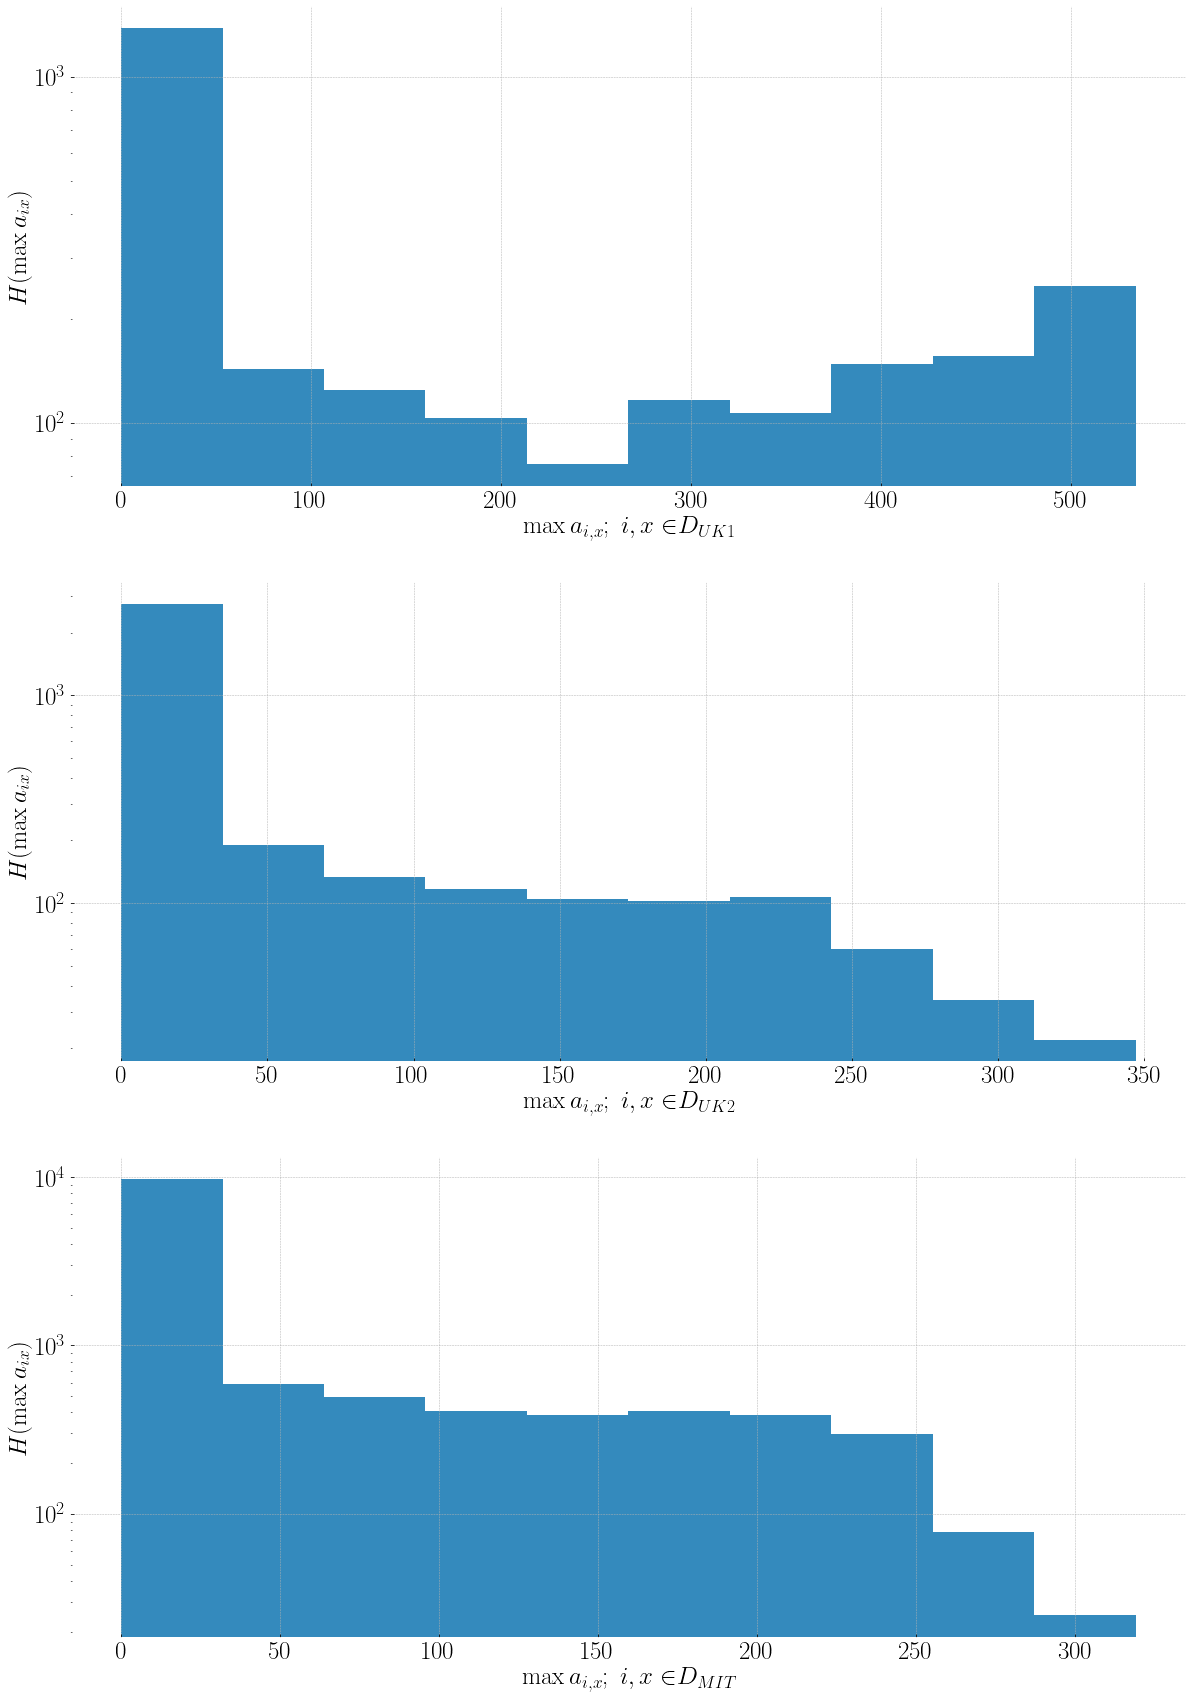

In [174]:
alldata = [uk1_calls2, uk2_calls2, mit_calls2]
xls = r"$\max{a_{i,x}}; \; i, x \in $"
dlab = [r"$D_{UK1}$", r"$D_{UK2}$", r"$D_{MIT}$"]

plt.figure(figsize=(20, 30))
for p in range(len(alldata)):
    plt.subplot(3,1,p + 1)
    plt.xlabel(xls + dlab[p])
    plt.ylabel(r"$H(\max{a_{ix}})$")
    plt.yscale("log")
    plt.hist(alldata[p].groupby(['ego', 'alter'])[['aclock']].max()['aclock'])

Considering the histograms above, I will make all alters to have a relationship with ego of **at most** 300 days.

In [175]:
uk1_calls3 = uk1_calls2.loc[uk1_calls2['aclock'] <= 200]
uk2_calls3 = uk2_calls2.loc[uk2_calls2['aclock'] <= 200]
mit_calls3 = mit_calls2.loc[mit_calls2['aclock'] <= 200]

In [160]:
[max(uk1_calls3['uclock']), max(uk2_calls3['uclock']), max(mit_calls3['uclock'])]

[378, 363, 294]

In [46]:
a = uk2_calls.groupby(['ego', 'alter'])[['uclock']].min()

In [47]:
b = list(a.index)

In [48]:
c = b[0]

In [49]:
a.at[c, 'uclock']

248

In [75]:
uk2_lives['C07779270485']['C01132307972']

{'t0': 192, 'tf': 192, 'nij': 1, 'ell': 0}

In [176]:
timer0 = time.time()
mit_calls4 = pd.DataFrame()
T = max(mit_calls3['uclock'])
for ego in mit_calls3['ego'].unique():
    df = mit_calls3.loc[mit_calls3['ego'] == ego]
    for alter in df['alter'].unique():
        t0 = mit_lives[ego][alter]['t0']
        if t0 <= (T - 200):
            df2 = df.loc[df['alter'] == alter]
            mit_calls4 = mit_calls4.append(df2).reset_index(drop=True)
print(f'This block took {time.time() - timer0}')

This block took 7.25197434425354


In [118]:
timer0 = time.time()
uk1_calls4 = pd.DataFrame()
T = max(uk1_calls3['uclock'])
for ego in uk1_calls3['ego'].unique():
    df = uk1_calls3.loc[uk1_calls3['ego'] == ego]
    for alter in df['alter'].unique():
        t0 = uk1_lives[ego][alter]['t0']
        if t0 <= (T - 200):
            df2 = df.loc[df['alter'] == alter]
            uk1_calls4 = uk1_calls4.append(df2).reset_index(drop=True)
print(f'This block took {time.time() - timer0}')

This block took 2.457087278366089


In [121]:
timer0 = time.time()
uk2_calls4 = pd.DataFrame()
T = max(uk2_calls3['uclock'])
for ego in uk2_calls3['ego'].unique():
    df = uk2_calls3.loc[uk2_calls3['ego'] == ego]
    for alter in df['alter'].unique():
        t0 = uk2_lives[ego][alter]['t0']
        if t0 <= (T - 200):
            df2 = df.loc[df['alter'] == alter]
            uk2_calls4 = uk2_calls4.append(df2).reset_index(drop=True)
print(f'This block took {time.time() - timer0}')

This block took 1.5901329517364502


In [162]:
mit_calls4.head()

,ego,alter,time,uclock,aclock
0,fa10-01-01,6536ecacb91447a66c001bce6d2a988864a2f5b4,2011-06-06 15:35:59,253,195
1,fa10-01-01,7bcb87774bb1a0ee9bc10c32bf944b9219c7676a,2011-05-09 21:50:12,226,154
2,fa10-01-01,9a66909754ba21599c7baf1708b3593f36b88f8,2011-05-30 17:33:04,247,162
3,fa10-01-01,a5096f3b8eb462a36889327f7a98f0ee8bde6ea5,2011-06-09 10:45:19,256,190
4,fa10-01-01,a95763619d18c324c08011333e93c55d804d4503,2011-05-04 07:53:33,220,137


## $\lambda$ distributions by $F$

In [177]:
%time mit_dff = pc.get_f(mit_calls4, 'all', 60, 7)
mit_allf = []
for ego in mit_dff.keys():
    for alter in mit_dff[ego].keys():
        df = mit_dff[ego][alter].loc[mit_dff[ego][alter]['alpha'] == 1]
        for i in df['f']:
            mit_allf.append(i)
        
print([max(mit_allf), min(mit_allf), len(mit_allf)])
p = [np.percentile(mit_allf, q) for q in (33, 66, 100)]
p

CPU times: user 8.93 s, sys: 22.2 ms, total: 8.95 s
Wall time: 8.95 s
[405, 1, 1580]


[2.0, 6.0, 405.0]

In [178]:
%time mit_fdist = f_histell(mit_dff, 1, p)

CPU times: user 1.4 s, sys: 28.7 ms, total: 1.43 s
Wall time: 1.3 s


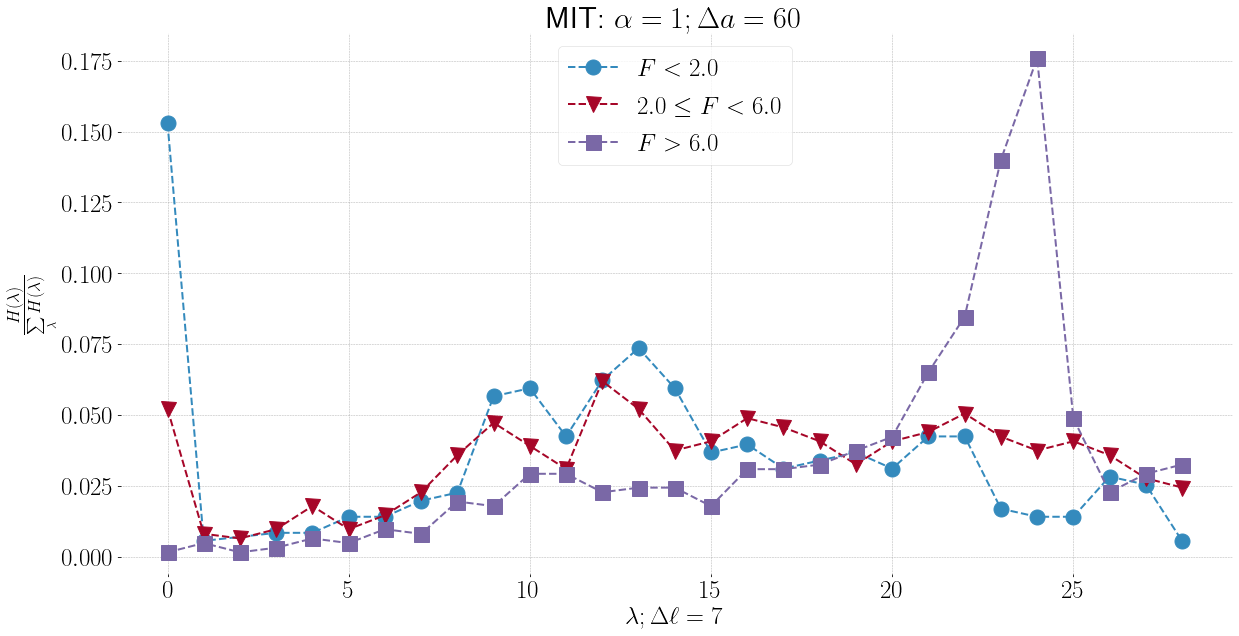

In [180]:
legends = [fr"$F < {p[0]}$", fr"${p[0]} \leq F < {p[1]}$", fr"$F > {p[1]}$", r"All $F$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(mit_fdist[i].index, mit_fdist[i][0] / sum(mit_fdist[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

In [127]:
%time uk1_dff = pc.get_f(uk1_calls4, 'all', 60, 7)
uk1_allf = []
for ego in uk1_dff.keys():
    for alter in uk1_dff[ego].keys():
        df = uk1_dff[ego][alter].loc[uk1_dff[ego][alter]['alpha'] == 1]
        for i in df['f']:
            uk1_allf.append(i)
        
print([max(uk1_allf), min(uk1_allf), len(uk1_allf)])
p = [np.percentile(uk1_allf, q) for q in (33, 66, 100)]
p

CPU times: user 3.99 s, sys: 29.1 ms, total: 4.02 s
Wall time: 4.03 s
[264, 1, 814]


[2.0, 7.0, 264.0]

In [128]:
%time uk1_fdist = f_histell(uk1_dff, 1, p)

CPU times: user 715 ms, sys: 24.6 ms, total: 740 ms
Wall time: 645 ms


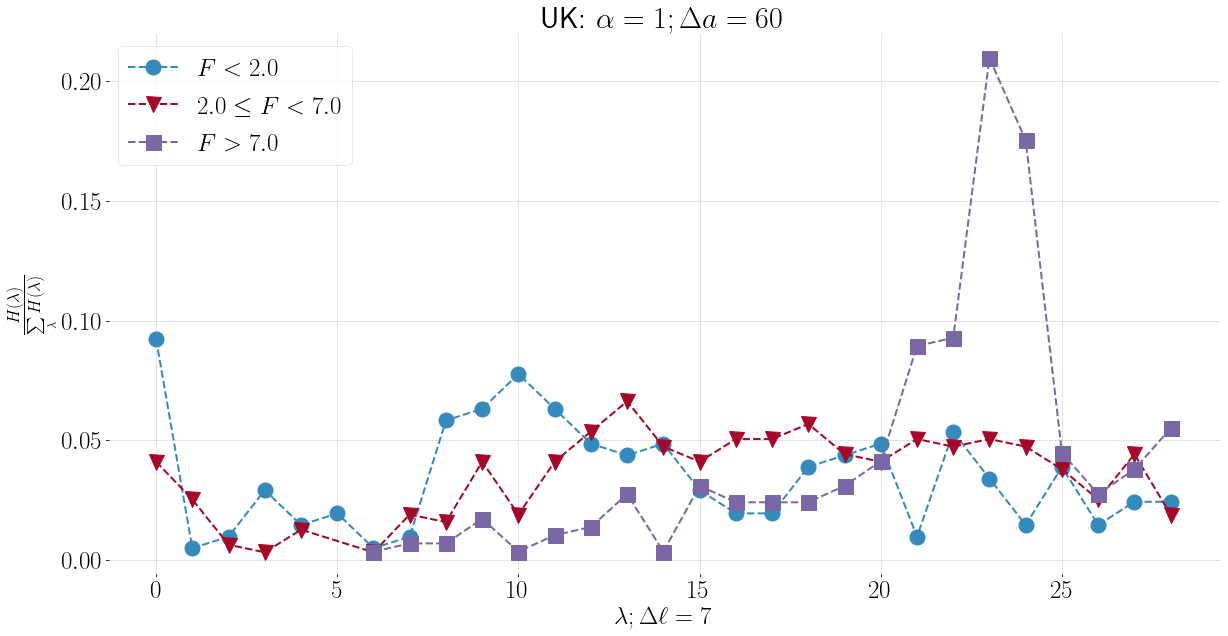

In [129]:
legends = [fr"$F < {p[0]}$", fr"${p[0]} \leq F < {p[1]}$", fr"$F >{p[1]}$", r"All $F$"]
plt.title(r"UK: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(uk1_fdist[i].index, uk1_fdist[i][0] / sum(uk1_fdist[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

In [130]:
%time uk2_dff = pc.get_f(uk2_calls4, 'all', 60, 7)
uk2_allf = []
for ego in uk2_dff.keys():
    for alter in uk2_dff[ego].keys():
        df = uk2_dff[ego][alter].loc[uk2_dff[ego][alter]['alpha'] == 1]
        for i in df['f']:
            uk2_allf.append(i)
        
print([max(uk2_allf), min(uk2_allf), len(uk2_allf)])
p = [np.percentile(uk1_allf, q) for q in (33, 66, 100)]
p

CPU times: user 2.74 s, sys: 0 ns, total: 2.74 s
Wall time: 2.74 s
[269, 1, 404]


[2.0, 7.0, 264.0]

In [131]:
%time uk2_fdist = f_histell(uk2_dff, 1, p)

CPU times: user 446 ms, sys: 10.6 ms, total: 457 ms
Wall time: 417 ms


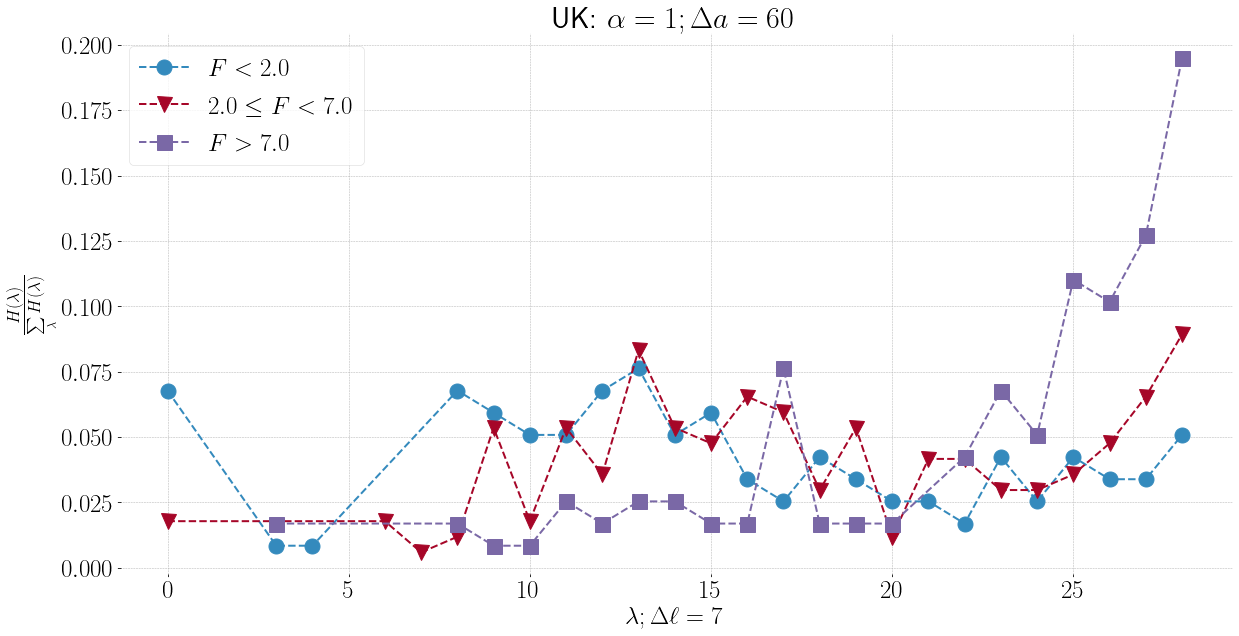

In [132]:
legends = [fr"$F < {p[0]}$", fr"${p[0]} \leq F < {p[1]}$", fr"$F >{p[1]}$", r"All $F$"]
plt.title(r"UK: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(uk2_fdist[i].index, uk2_fdist[i][0] / sum(uk2_fdist[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

## Changing $F$ groups

It makes the results less clear in MIT, but not in the UK

In [137]:
p = [2, 5, 7, 10, 12, 15, 1000]
%time mit_fdist2 = f_histell(mit_dff, 1, p)

CPU times: user 1.83 s, sys: 53.6 ms, total: 1.89 s
Wall time: 1.64 s


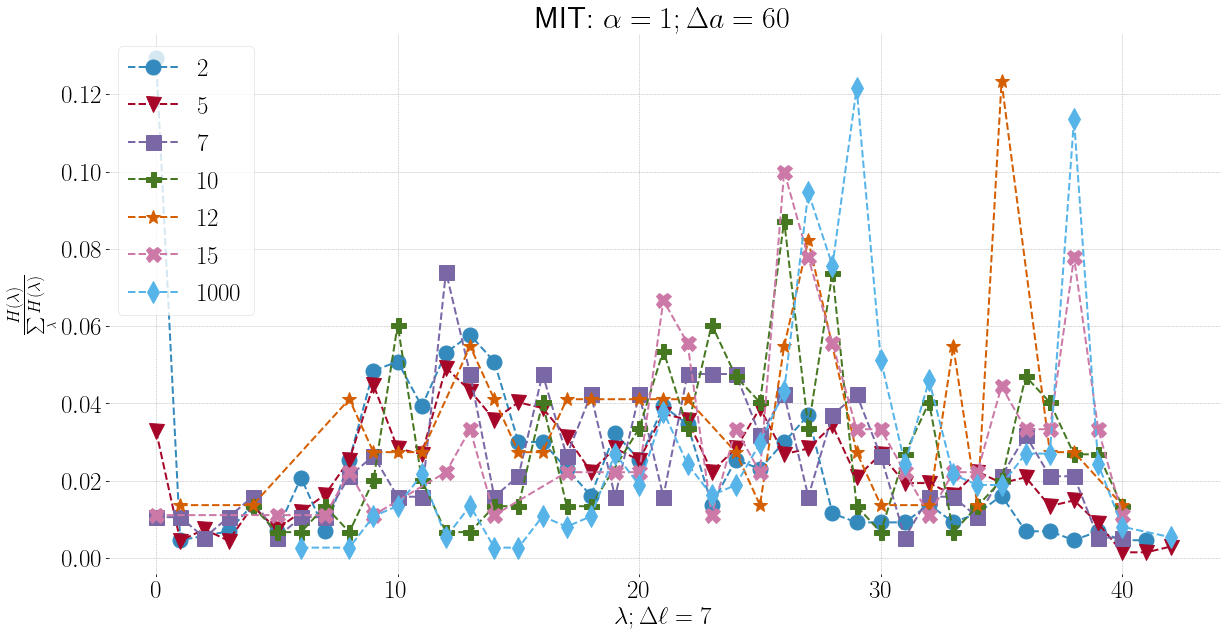

In [140]:
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(p)):
    plt.plot(mit_fdist2[i].index, mit_fdist2[i][0] / sum(mit_fdist2[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"${p[i]}$")
plt.legend()

In [141]:
p = [5, 10, 1000]
%time uk1_fdist2 = f_histell(uk1_dff, 1, p)

CPU times: user 748 ms, sys: 5.24 ms, total: 753 ms
Wall time: 639 ms


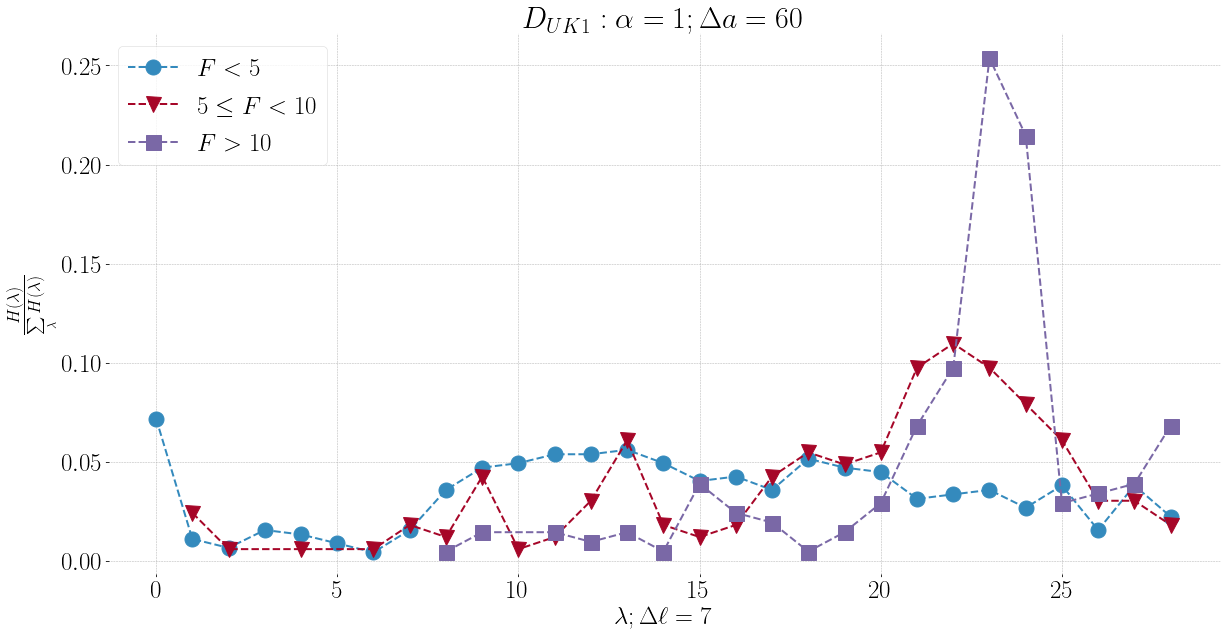

In [142]:
legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"$D_{UK1}: \alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(uk1_fdist2[i].index, uk1_fdist2[i][0] / sum(uk1_fdist2[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

CPU times: user 477 ms, sys: 7.7 ms, total: 484 ms
Wall time: 420 ms


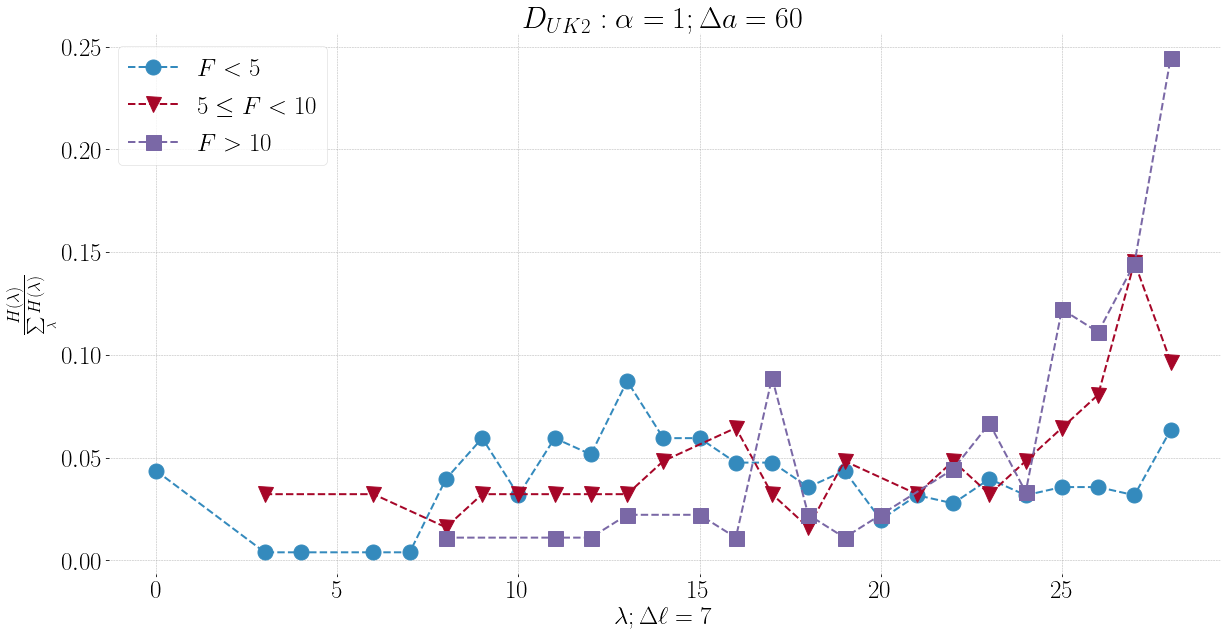

In [143]:
p = [5, 10, 1000]
%time uk2_fdist2 = f_histell(uk2_dff, 1, p)

legends = [fr"$F < {int(p[0])}$", fr"${int(p[0])} \leq F < {int(p[1])}$", fr"$F > {int(p[1])}$", r"All $F$"]
plt.title(r"$D_{UK2}: \alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(uk2_fdist2[i].index, uk2_fdist2[i][0] / sum(uk2_fdist2[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Define groups as *calls up to a certain number*

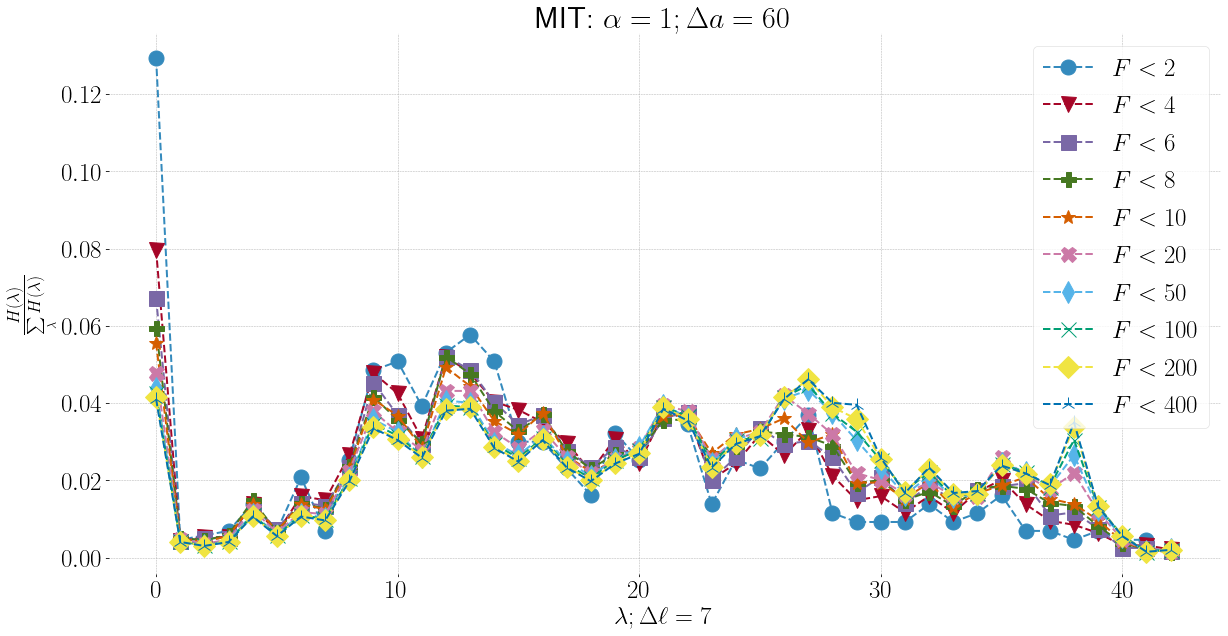

In [144]:
mit_test = {}
c = [2, 4, 6, 8, 10, 20, 50, 100, 200, 400]
for ego in mit_dff.keys():
    for alter in mit_dff[ego].keys():
        df = mit_dff[ego][alter].loc[mit_dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            #test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                for cut in c:
                    if f < cut:
                        mit_test[c.index(cut)] = mit_test.get(c.index(cut), {})
                        mit_test[c.index(cut)][lamb] = mit_test[c.index(cut)].get(lamb, 0) + 1
            
for i in mit_test.keys():
    mit_test[i] = pd.DataFrame.from_dict(mit_test[i], orient='index')
    mit_test[i].sort_index(inplace=True)

plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(mit_test)):
    plt.plot(mit_test[i].index, mit_test[i][0] / sum(mit_test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F < {c[i]}$")
plt.legend()

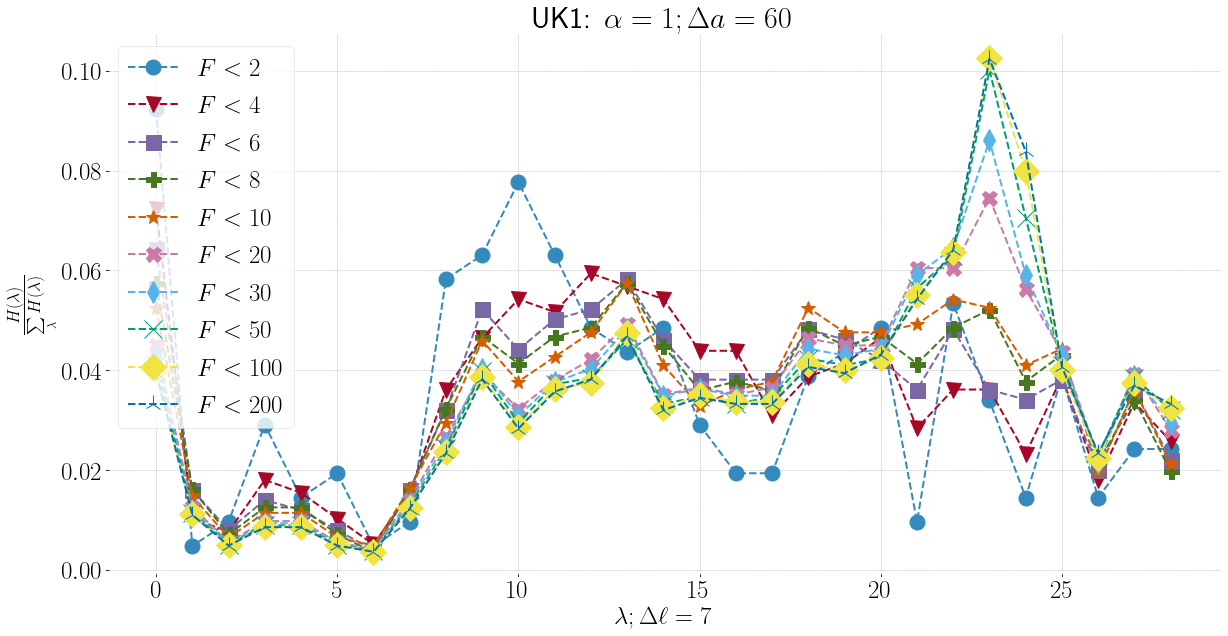

In [145]:
uk1_test = {}
c = [2, 4, 6, 8, 10, 20, 30, 50, 100, 200]
for ego in uk1_dff.keys():
    for alter in uk1_dff[ego].keys():
        df = uk1_dff[ego][alter].loc[uk1_dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            #test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                for cut in c:
                    if f < cut:
                        uk1_test[c.index(cut)] = uk1_test.get(c.index(cut), {})
                        uk1_test[c.index(cut)][lamb] = uk1_test[c.index(cut)].get(lamb, 0) + 1
            
for i in uk1_test.keys():
    uk1_test[i] = pd.DataFrame.from_dict(uk1_test[i], orient='index')
    uk1_test[i].sort_index(inplace=True)

plt.title(r"UK1: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(uk1_test)):
    if i >= len(uk1_test) - 3:
        plt.plot(uk1_test[i].index, uk1_test[i][0] / sum(uk1_test[i][0]), marker=markers[i], linestyle="--", markersize=18, label=fr"$F < {c[i]}$")
    else:
        plt.plot(uk1_test[i].index, uk1_test[i][0] / sum(uk1_test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F < {c[i]}$")
plt.legend()

## Update the function

In [ ]:
def f_histell(fresult, alpha_fixed, cut_points, uptoapoint=False):
    test = {}
    if uptoapoint:
        for ego in fresult.keys():
            for alter in fresult[ego].keys():
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
                if len(df) > 0:
                    lamb = df.iloc[0]['lambda']
                    for f in df['f']:
                        for cut in cut_points:
                            if f < cut:
                                test[cut_points.index(cut)] = test.get(cut_points.index(cut), {})
                                test[cut_points.index(cut)][lamb] = test[cut_points.index(cut)].get(lamb, 0) + 1
                            
    else:
        for i in range(len(cut_points) + 1):
            test[i] = {}
        for ego in fresult.keys():
            for alter in fresult[ego].keys():
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
                if len(df) > 0:
                    lamb = df.iloc[0]['lambda']
                    for f in df['f']:
                        test[len(cut_points)][lamb] = test[len(cut_points)].get(lamb, 0) + 1
                        for c in range(len(cut_points)):
                            if (c == 0) and (f < cut_points[0]):
                                test[c][lamb] = test[c].get(lamb, 0) + 1
                            elif (c in range(1, len(cut_points) - 1)) and (f >= cut_points[c - 1]) and (f < cut_points[c]):
                                test[c][lamb] = test[c].get(lamb, 0) + 1
                            elif (c == len(cut_points) - 1) and  (f >= cut_points[-2]):
                                test[c][lamb] = test[c].get(lamb, 0) + 1
                

    for i in test.keys():
        test[i] = pd.DataFrame.from_dict(test[i], orient='index')
        test[i].sort_index(inplace=True)
        
    return test

## Certain number of phone calls and more

In [ ]:
mit_test2 = {}
c = [2, 4, 6, 8, 10, 20, 50, 100, 200, 400]
for ego in mit_dff.keys():
    for alter in mit_dff[ego].keys():
        df = mit_dff[ego][alter].loc[mit_dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            #test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                for cut in c:
                    if f >= cut:
                        mit_test2[c.index(cut)] = mit_test2.get(c.index(cut), {})
                        mit_test2[c.index(cut)][lamb] = mit_test2[c.index(cut)].get(lamb, 0) + 1
            
for i in mit_test2.keys():
    mit_test2[i] = pd.DataFrame.from_dict(mit_test2[i], orient='index')
    mit_test2[i].sort_index(inplace=True)

plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(mit_test2)):
    plt.plot(mit_test2[i].index, mit_test2[i][0] / sum(mit_test2[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F \geq {c[i]}$")
plt.legend()

In [ ]:
uk_test2 = {}
c = [2, 4, 6, 8, 10, 20, 30, 50, 100, 200]
for ego in uk_dff.keys():
    for alter in uk_dff[ego].keys():
        df = uk_dff[ego][alter].loc[uk_dff[ego][alter]['alpha'] == 1]
        if len(df) > 0:
            lamb = df.iloc[0]['lambda']
            #test[3][lamb] = test[3].get(lamb, 0) + 1
            for f in df['f']:
                for cut in c:
                    if f >= cut:
                        uk_test2[c.index(cut)] = uk_test2.get(c.index(cut), {})
                        uk_test2[c.index(cut)][lamb] = uk_test2[c.index(cut)].get(lamb, 0) + 1
            
for i in uk_test2.keys():
    uk_test2[i] = pd.DataFrame.from_dict(uk_test2[i], orient='index')
    uk_test2[i].sort_index(inplace=True)

plt.title(r"UK: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(len(uk_test2)):
    if i >= len(uk_test2) - 3:
        plt.plot(uk_test2[i].index, uk_test2[i][0] / sum(uk_test2[i][0]), marker=markers[i], linestyle="--", markersize=18, label=fr"$F \geq {c[i]}$")
    else:
        plt.plot(uk_test2[i].index, uk_test2[i][0] / sum(uk_test2[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F \geq {c[i]}$")
plt.legend()

# Trying modifications to improve results 

## Use $\alpha = 0$ and $\alpha = 2$

In [ ]:
cuk = [2, 4, 6, 8, 10, 20, 30, 50, 100, 200]
uk1_fdist0 = f_histell(uk1_dff, 0, cuk, True)
uk1_fdist1 = f_histell(uk1_dff, 1, cuk, True)
uk1_fdist2 = f_histell(uk1_dff, 2, cuk, True)
uk2_fdist0 = f_histell(uk2_dff, 0, cuk, True)
uk2_fdist1 = f_histell(uk2_dff, 1, cuk, True)
uk2_fdist2 = f_histell(uk2_dff, 2, cuk, True)
cmit = [2, 4, 6, 8, 10, 20, 50, 100, 200, 400]
mit_fdist0 = f_histell(mit_dff, 0, cmit, True)
mit_fdist1 = f_histell(mit_dff, 1, cmit, True)
mit_fdist2 = f_histell(mit_dff, 2, cmit, True)

In [ ]:
7 % 3

In [ ]:
alldata = [uk1_fdist0, uk2_fdist0, mit_fdist0, uk1_fdist1, uk2_fdist1, mit_fdist1, uk1_fdist2, uk2_fdist2, mit_fdist2]

plt.figure(figsize = (36, 24))
for p in range(len(alldata)):
    if p % 3 == 0:
        plt.subplot(3, 3, p + 1)
        data = alldata[p]
        plt.title(fr"UK1: $\alpha = {[0,1,2][p//3]}; \Delta a  = 60$")
        plt.xlabel(r"$\lambda; \Delta \ell = 7$")
        plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
        for i in range(len(data)):
            if i >= len(data) - 3:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=18, label=fr"$F < {cuk[i]}$")
            else:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F < {cuk[i]}$")
        plt.legend()
    elif p % 3 == 1:
        plt.subplot(3, 3, p + 1)
        data = alldata[p]
        plt.title(fr"UK2: $\alpha = {[0,1,2][(p - 1)//3]}; \Delta a  = 60$")
        plt.xlabel(r"$\lambda; \Delta \ell = 7$")
        plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
        for i in range(len(data)):
            if i >= len(data) - 3:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=18, label=fr"$F < {cuk[i]}$")
            else:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F < {cuk[i]}$")
        plt.legend()
    else:
        plt.subplot(3, 3, p + 1)
        data = alldata[p]
        plt.title(fr"MIT: $\alpha = {[0, 1, 2][(p - 2)//3]}; \Delta a  = 60$")
        plt.xlabel(r"$\lambda; \Delta \ell = 7$")
        plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
        for i in range(len(data)):
            if i >= len(data) - 3:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=18, label=fr"$F < {cmit[i]}$")
            else:
                plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr"$F < {cmit[i]}$")
        plt.legend()

## Try $\Delta a = 30$

In [ ]:
uk1_dff2 = pc.get_f(uk1_calls4, 'all', 30, 7)
uk2_dff2 = pc.get_f(uk2_calls4, 'all', 30, 7)
mit_dff2 = pc.get_f(mit_calls4, 'all', 30, 7)

c = [2, 4, 6, 8, 10, 20, 30, 50, 100, 200]

uk1_fdist = []
uk2_fdist = []
mit_fdist = []
for i in range(3):
    uk1_fdist.append(f_histell(uk1_dff2, i, [2, 6, 10, 1000]))
    uk2_fdist.append(f_histell(uk2_dff2, i, [2, 6, 10, 1000]))
    mit_fdist.append(f_histell(mit_dff2, i, [2, 6, 10, 1000]))

In [ ]:
alldata = [uk1_fdist[0], uk2_fdist[0], mit_fdist[0], uk1_fdist[1], uk2_fdist[1], mit_fdist[1], uk1_fdist[2], uk2_fdist[2], mit_fdist[2]]
c = [0, 2, 6, 10, '\infty']

plt.figure(figsize=(36,24))
for p in range(len(alldata)):
    plt.subplot(3, 3, p + 1)
    data = alldata[p]
    plt.title(fr"{['UK1', 'UK2', 'MIT'][p%3]}: $\alpha = {[0,1,2][p%3]}; \Delta a  = 30$")
    plt.xlabel(r"$\lambda; \Delta \ell = 7$")
    plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
    for i in range(len(c) - 1):
        plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[i], linestyle="--", markersize=15, label=fr'${c[i]} \leq F < {c[i + 1]}$')
    plt.legend()

## Use bins of $F$ for the series

I will introduce the quantity $\phi(F)$, defined as

$$ \phi(F) = \left\lfloor \frac{F}{\Delta F}\right\rfloor$$

To test it, I will include them into each dataset

In [ ]:
a = [2, 4, 6, 100]
b = [0] + a

In [ ]:
for i in range(len(b) - 1):
    print((b[i], b[i + 1]))

In [ ]:
def f_histell(fresult, alpha_fixed, cut_points, uptoapoint=False, binned=False, deltaF=5):
    test = {}
    if uptoapoint:
        for ego in fresult.keys():
            for alter in fresult[ego].keys():
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
                if len(df) > 0:
                    lamb = df.iloc[0]['lambda']
                    for f in df['f']:
                        for cut in cut_points:
                            if f < cut:
                                df2 = df.loc[df['f'] < cut]
                                test[cut_points.index(cut)] = test.get(cut_points.index(cut), {})
                                test[cut_points.index(cut)][lamb] = test[cut_points.index(cut)].get(lamb, 0) + sum(df2['f'])
                                
    elif binned:
        for ego in fresult.keys():
            for alter in fresult[ego].keys():
                fresult[ego][alter]['phi'] = fresult[ego][alter]['f'] // deltaF
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
                if len(df) > 0:
                    lamb = df.iloc[0]['lambda']
                    for phi in df['phi'].unique():
                        df2 = df.loc[df['phi'] == phi]
                        test[phi] = test.get(phi, {})
                        test[phi][lamb] = test[phi].get(lamb, 0) + sum(df2['f'])
                        #test[phi][lamb] = test[phi].get(lamb, 0) + 1
                
                            
    else:
        cutp = [0] + cut_points
        for ego in fresult.keys():
            for alter in fresult[ego].keys():
                df = fresult[ego][alter].loc[fresult[ego][alter]['alpha'] == alpha_fixed]
                if len(df) > 0:
                    lamb = df.iloc[0]['lambda']
                    for i in range(len(cutp) - 1):
                        df2 = df.loc[(df['f'] >= cutp[i]) & (df['f'] < cutp[i + 1])]
                        test[i] = test.get(i, {})
                        test[i][lamb] = test[i].get(lamb, 0) + sum(df2['f'])
                        

    for i in test.keys():
        test[i] = pd.DataFrame.from_dict(test[i], orient='index')
        test[i].sort_index(inplace=True)
        
    return test

In [ ]:
uk1_fdist = f_histell(uk1_dff, 1, [], binned=True, deltaF=10)
uk2_fdist = f_histell(uk2_dff, 1, [], binned=True, deltaF=10)
mit_fdist = f_histell(mit_dff, 1, [], binned=True, deltaF=10)

In [ ]:
alldata = [uk1_fdist, uk2_fdist, mit_fdist]
plt.figure(figsize=(20, 30))
for p in range(len(alldata)):
    data = alldata[p]
    dataseries = sorted(list(data.keys()))[:10]
    #dataseries += sorted(list(data.keys()))[-3:]
    plt.subplot(3,1,p + 1)
    plt.title(fr"{['UK1', 'UK2', 'MIT'][p]}: $\alpha = {[0,1,2][p]}; \Delta a  = 60$")
    plt.xlabel(r"$\lambda; \Delta \ell = 7$")
    plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
    idx = 0
    for i in dataseries:
        plt.plot(data[i].index, data[i][0] / sum(data[i][0]), marker=markers[idx], linestyle="--", markersize=15, label=fr"$\phi = {i}; \Delta F = 10$")
        idx += 1
    plt.legend()

# Using the same dataset as above, but now with $b$

The dataset used in the previous plot contains all calls starting 1 month after ego appeared; and all alters limited to $a \leq 200$

In [ ]:
%time dfb = pc.get_b(dff, 'lambda')

In [ ]:
allb = []
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        allb.append(df.at[i, 'g'])
        
print([max(allb), min(allb), len(allb)])
plt.hist(allb, bins=100)

In [ ]:
p33, p66 = np.percentile(allb, 33), np.percentile(allb, 66)
test = {}
for i in range(4):
    test[i] = {}
    
for ego in blamb.keys():
    df = blamb[ego].loc[blamb[ego]['alpha'] == 1]
    for i in df.index:
        lamb = df.at[i, 'lambda']
        b = df.at[i, 'g']
        test[3][lamb] = test[3].get(lamb, 0) + 1
        if b < p33:
            test[0][lamb] = test[0].get(lamb, 0) + 1
        elif (b >= p33) and (b < p66):
            test[1][lamb] = test[1].get(lamb, 0) + 1
        else:
            test[2][lamb] = test[2].get(lamb, 0) + 1

for i in test.keys():
    test[i] = pd.DataFrame.from_dict(test[i], orient='index')
    test[i].sort_index(inplace=True)

In [ ]:
legends = [fr"$b < {int(p33)}$", fr"${int(p33)} \leq b < {int(p66)}$", fr"$b > {int(p66)}$", r"All $b$"]
plt.title(r"MIT: $\alpha = 1; \Delta a  = 60$")
plt.xlabel(r"$\lambda; \Delta \ell = 7$")
plt.ylabel(r"$\frac{H(\lambda)}{\sum\limits_{\lambda} H(\lambda)}$")
for i in range(3):
    plt.plot(test[i].index, test[i][0] / sum(test[i][0]), marker=markers[i], linestyle="--", markersize=15, label=legends[i])
plt.legend()

# Testing functions

In [ ]:
def get_f(callsdf, theego, lives_dict, bina, binell):
    '''
    This method outputs a dataframe with one row per (a, ell) combination, and the number
    of phone calls ego made to alters with that combination of parameters. The arguments are
    callsdf             : a dataframe produces with the "allcalls" or "remove_alters" methods
    theego              : specify an ego for results only using it. If the 'all' argument is
                        passed, it will calculate a dataframe per ego
    lives_dict          : dictionary produces with the "lives_dictionary" method
    bina                : the value for \Delta a
    binell              : \Delta ell
    '''
    if theego != 'all':
        df1 = callsdf.loc[callsdf['ego'] == theego]
    else:
        df1 = copy.deepcopy(callsdf)

    f = {}
    for ego in df1['ego'].unique():
        f[ego] = {}
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            f[ego][alter] = pd.DataFrame()
            df3 = df2.loc[df2['alter'] == alter]
            alla = set([i // bina for i in df3['aclock'].unique()])
            lamb = lives_dict[ego][alter]['ell'] // binell
            idx = 0
            for a in alla:
                f[ego][alter].at[idx, 'lamb'] = lamb
                f[ego][alter].at[idx, 'alpha'] = a
                idx += 1
            f[ego][alter]['f'] = 0
            for c in df3.index:
                a = df3.at[c, 'aclock']  // bina
                iidx = list(f[ego][alter].loc[f[ego][alter]['alpha'] == a].index)[0]
                f[ego][alter].at[iidx, 'f'] += 1

    return f

In [ ]:
%time aaa = get_f(mit_calls, 'all', mit_lives, 60, 7)

In [ ]:
counter = 0
for ego in aaa.keys():
    for alter in aaa[ego].keys():
        df = aaa[ego][alter]
        print(list(df['lamb']))
        counter += 1
        if counter == 20:
            break
    if counter  == 20:
        break

In [ ]:
def get_f2(callsdf, theego, bina, binell):
    '''
    This method outputs a dataframe with one row per (a, ell) combination, and the number
    of phone calls ego made to alters with that combination of parameters. The arguments are

    callsdf             : a dataframe produces with the "allcalls" or "remove_alters" methods
    theego              : specify an ego for results only using it. If the 'all' argument is
                        passed, it will calculate a dataframe per ego
    lives_dict          : dictionary produces with the "lives_dictionary" method
    bina                : the value for \Delta a
    binell              : \Delta ell
    '''
    if theego != 'all':
        df1 = callsdf.loc[callsdf['ego'] == theego]
    else:
        df1 = callsdf.copy()

    f = {}
    for ego in df1['ego'].unique():
        f[ego] = {}
        df2 = df1.loc[df1['ego'] == ego]
        for alter in df2['alter'].unique():
            df3 = df2.loc[df2['alter'] == alter]
            df3.sort_values(by='time', inplace=True)
            lamb = (df3.iloc[-1]['uclock'] - df3.iloc[0]['uclock']) // binell
            df3['alpha'] = df3['aclock'] // bina
            tmp = df3.groupby('alpha').size()
            f[ego][alter] = pd.DataFrame({'lambda': lamb, 'alpha': tmp.index, 'f': tmp})
            f[ego][alter].reset_index(drop=True, inplace=True)
    return f

In [ ]:
%time bbb = get_f2(mit_calls, 'all', 60, 7)

In [ ]:
counter = 0
for ego in bbb.keys():
    for alter in bbb[ego].keys():
        df = bbb[ego][alter]
        print(list(df['lambda']))
        counter += 1
        if counter == 20:
            break
    if counter  == 20:
        break

In [ ]:
a = mit_calls.groupby(['ego', 'alter'])[['aclock']].min().rename(columns={'aclock': 't0'})
b = mit_calls.groupby(['ego', 'alter'])[['aclock']].max().rename(columns={'aclock': 'tf'})

In [ ]:
c = mit_calls.groupby(['ego', 'alter'])[['aclock']].count().rename(columns={'aclock': 'nij'})

In [ ]:
d = a.merge(b, left_index=True, right_index=True)
d = d.merge(c, left_index=True, right_index=True)

In [ ]:
d['ell'] = d['tf'] - d['t0']

In [ ]:
%time aaa = pc.lives_dictionary(mit_calls)

In [ ]:
%time bbb = ld(mit_calls)

In [ ]:
aaa[egolist[0]][alist[1]]

In [ ]:
bbb[egolist[0]][alist[1]]['ell']

In [ ]:
alist = list(fall[egolist[0]].keys())
fall[egolist[0]][alist[1]]

In [ ]:
aa = pd.DataFrame({1: ['a', 'a', 'b', 'c', 'c', 'c'], 2: 'hhhh', 3: list(range(6))})
aa

In [ ]:
bb = pd.DataFrame({1:['e', 'e', 'e', 'f', 'g', 'g', 'g'], 2: 'rock', 3:list(range(6, 13))})

In [ ]:
aa = aa.append(bb).reset_index(drop=True)
aa

In [ ]:
aa.groupby(1)